In [338]:
import pandas as pd
import numpy as np
import matplotlib.style
import matplotlib.pyplot as plt
import yfinance as yf
from pandas.conftest import axis_1

pd.options.display.float_format = '{:.4f}'.format
plt.style.use("seaborn-v0_8")
from itertools import product

In [339]:
symbol = "EURUSD=X"
start = "2018-01-01"
end = "2021-01-01"

In [340]:
df = yf.download(symbol, start, end, interval='1d').Close.to_frame()
df.rename(columns={"Close": "price"}, inplace=True)
df['returns'] = np.log(df['price'].div(df['price'].shift(1)))
df

[*********************100%%**********************]  1 of 1 completed


,price,returns
Date,,
2018-01-01,1.2005,NaN
2018-01-02,1.2012,0.0006
2018-01-03,1.2063,0.0043
2018-01-04,1.2010,-0.0044
2018-01-05,1.2069,0.0049
...,...,...
2020-12-25,1.2185,-0.0005
2020-12-28,1.2205,0.0017
2020-12-29,1.2223,0.0015


In [341]:
spread = 1.5 * 0.0001
halfspread = spread / 2
ptc = halfspread / df.price.mean()
ptc

np.float64(6.534796976280551e-05)

In [342]:
sma = 30
dev = 2

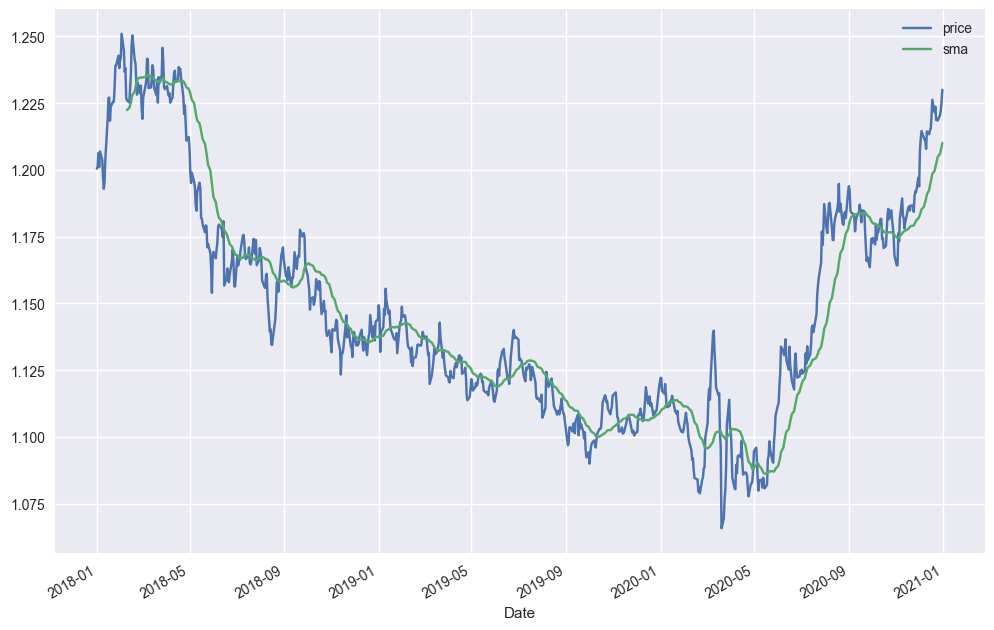

In [343]:
df['sma'] = df['price'].rolling(window=sma).mean()
df[['price', 'sma']].plot(figsize=(12, 8))
plt.show()

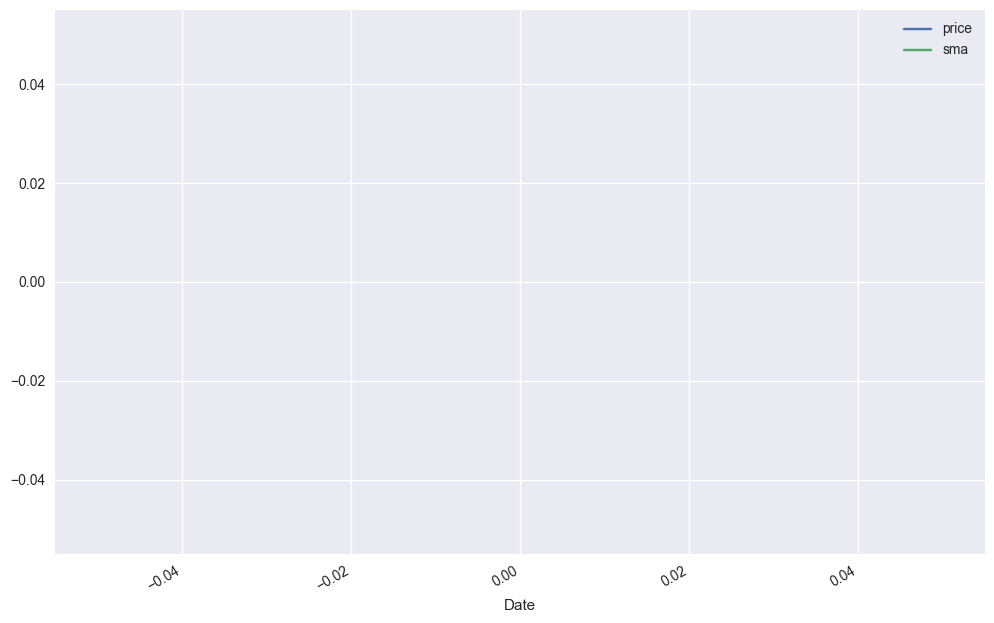

In [344]:
df.loc['2024-01':'2024-03', ['price', 'sma']].plot(figsize=(12, 8))
plt.show()

In [345]:
df['price'].rolling(sma).std()

Date
2018-01-01      NaN
2018-01-02      NaN
2018-01-03      NaN
2018-01-04      NaN
2018-01-05      NaN
              ...  
2020-12-25   0.0143
2020-12-28   0.0140
2020-12-29   0.0138
2020-12-30   0.0136
2020-12-31   0.0134
Name: price, Length: 783, dtype: float64

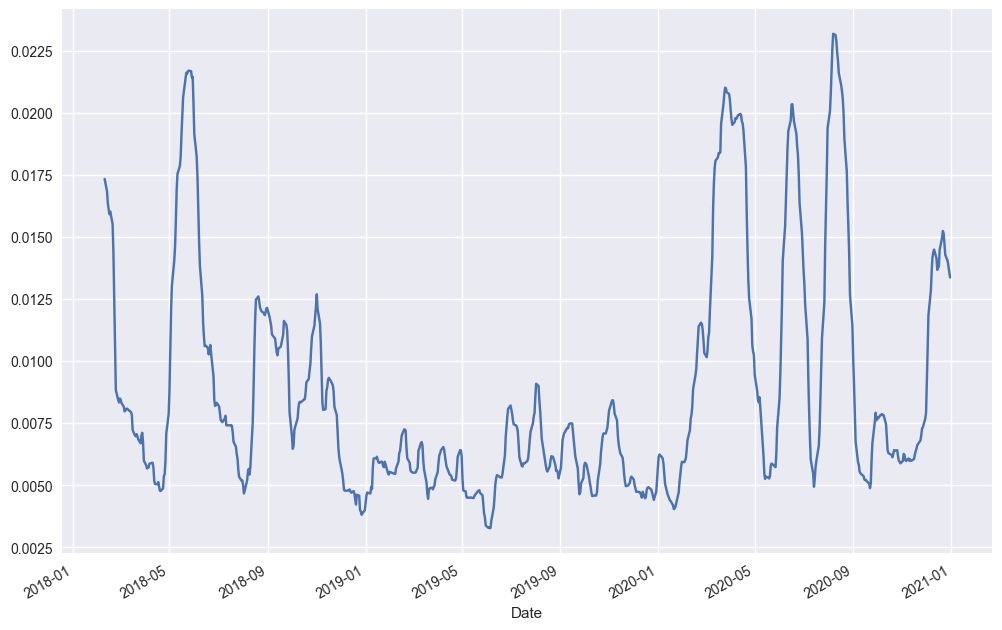

In [346]:
df['price'].rolling(sma).std().plot(figsize=(12, 8))
plt.show()

In [347]:
df['lower'] = df['sma'] - df['price'].rolling(sma).std() * dev
df['upper'] = df['sma'] + df['price'].rolling(sma).std() * dev
df.dropna()

,price,returns,sma,lower,upper
Date,,,,,
2018-02-09,1.2261,-0.0006,1.2224,1.1878,1.2571
2018-02-12,1.2253,-0.0006,1.2232,1.1896,1.2569
2018-02-13,1.2304,0.0042,1.2242,1.1915,1.2569
2018-02-14,1.2354,0.0041,1.2252,1.1930,1.2574
2018-02-15,1.2467,0.0091,1.2267,1.1949,1.2585
...,...,...,...,...,...
2020-12-25,1.2185,-0.0005,1.2049,1.1763,1.2334
2020-12-28,1.2205,0.0017,1.2061,1.1780,1.2341
2020-12-29,1.2223,0.0015,1.2073,1.1797,1.2348


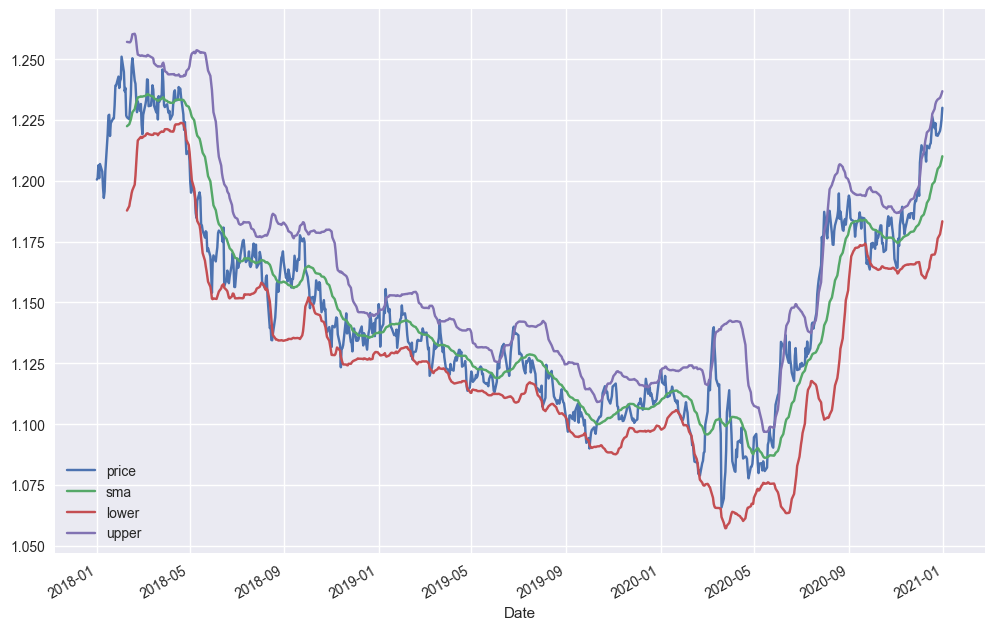

In [348]:
df[['price', 'sma', 'lower', 'upper']].plot(figsize=(12, 8))
plt.show()

In [349]:
def bollinger_position(price, lower, upper):
    if price < lower: return 1  # oversold -> go long
    if price > upper: return -1  # oversold -> go long
    else: return np.nan


df['distance'] = df.price - df.sma
df['position'] = df.apply(lambda x: bollinger_position(x.price, x.lower, x.upper), axis=1)
df['position'] = np.where(df.distance * df.distance.shift(1) < 0,  0, df['position'])
df.position = df.position.ffill().fillna(0)

<Axes: >

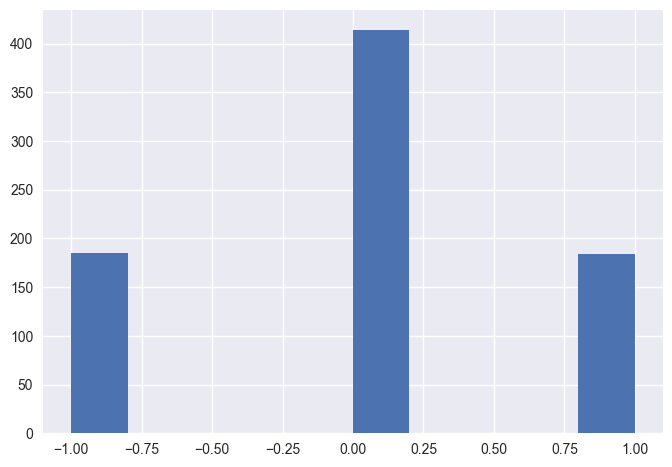

In [350]:
df.position.hist()

In [351]:
df

,price,returns,sma,lower,upper,distance,position
Date,,,,,,,
2018-01-01,1.2005,NaN,NaN,NaN,NaN,NaN,0.0000
2018-01-02,1.2012,0.0006,NaN,NaN,NaN,NaN,0.0000
2018-01-03,1.2063,0.0043,NaN,NaN,NaN,NaN,0.0000
2018-01-04,1.2010,-0.0044,NaN,NaN,NaN,NaN,0.0000
2018-01-05,1.2069,0.0049,NaN,NaN,NaN,NaN,0.0000
...,...,...,...,...,...,...,...
2020-12-25,1.2185,-0.0005,1.2049,1.1763,1.2334,0.0136,-1.0000
2020-12-28,1.2205,0.0017,1.2061,1.1780,1.2341,0.0145,-1.0000
2020-12-29,1.2223,0.0015,1.2073,1.1797,1.2348,0.0151,-1.0000


In [352]:
df['strategy'] = df.position.shift(1) * df['returns']
df.dropna(inplace=True)

In [353]:
df['creturns'] = df['returns'].cumsum().apply(np.exp)
df['cstrategy'] = df['strategy'].cumsum().apply(np.exp)

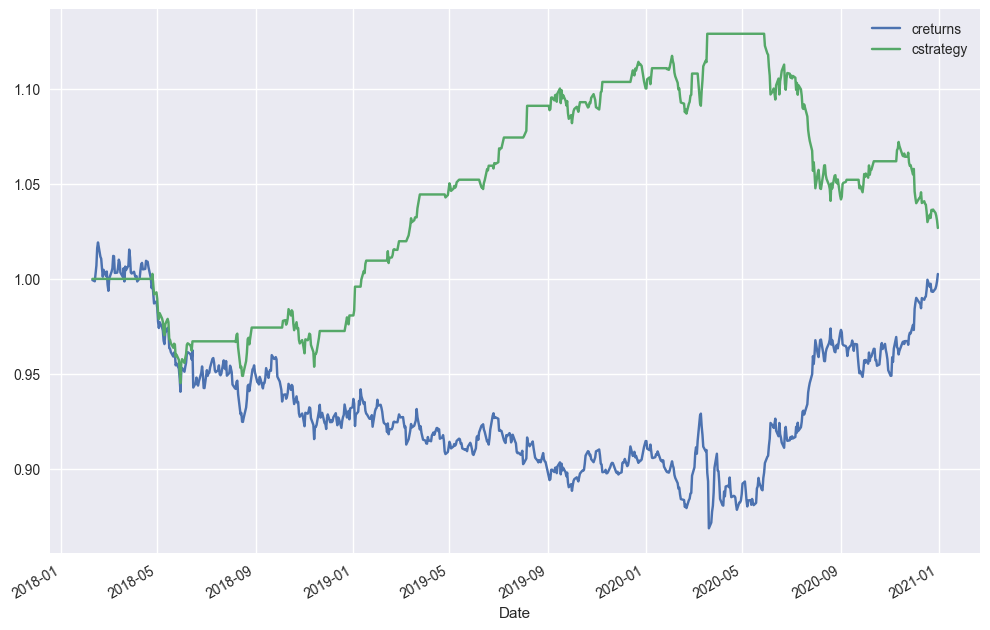

In [354]:
df[['creturns', 'cstrategy']].plot(figsize=(12, 8))
plt.show()

In [355]:
spread = 1.5 * 0.0001
halfspread = spread / 2
ptc = halfspread / df.price.mean()
ptc

np.float64(6.551172395298174e-05)

In [356]:
df['trades'] = df.position.diff().fillna(0).abs()
df

,price,returns,sma,lower,upper,distance,position,strategy,creturns,cstrategy,trades
Date,,,,,,,,,,,
2018-02-09,1.2261,-0.0006,1.2224,1.1878,1.2571,0.0037,0.0000,-0.0000,0.9994,1.0000,0.0000
2018-02-12,1.2253,-0.0006,1.2232,1.1896,1.2569,0.0020,0.0000,-0.0000,0.9988,1.0000,0.0000
2018-02-13,1.2304,0.0042,1.2242,1.1915,1.2569,0.0062,0.0000,0.0000,1.0029,1.0000,0.0000
2018-02-14,1.2354,0.0041,1.2252,1.1930,1.2574,0.0102,0.0000,0.0000,1.0070,1.0000,0.0000
2018-02-15,1.2467,0.0091,1.2267,1.1949,1.2585,0.0200,0.0000,0.0000,1.0162,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,1.2185,-0.0005,1.2049,1.1763,1.2334,0.0136,-1.0000,0.0005,0.9932,1.0365,0.0000
2020-12-28,1.2205,0.0017,1.2061,1.1780,1.2341,0.0145,-1.0000,-0.0017,0.9949,1.0348,0.0000
2020-12-29,1.2223,0.0015,1.2073,1.1797,1.2348,0.0151,-1.0000,-0.0015,0.9964,1.0332,0.0000


In [358]:
df.trades.value_counts()

trades
0.0000    713
1.0000     41
Name: count, dtype: int64

In [361]:
df['strategy_net'] = df.strategy - df.trades*ptc
df['cstrategy_net'] = df.strategy_net.cumsum().apply(np.exp)
df

,price,returns,sma,lower,upper,distance,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
Date,,,,,,,,,,,,,
2018-02-09,1.2261,-0.0006,1.2224,1.1878,1.2571,0.0037,0.0000,-0.0000,0.9994,1.0000,0.0000,-0.0000,1.0000
2018-02-12,1.2253,-0.0006,1.2232,1.1896,1.2569,0.0020,0.0000,-0.0000,0.9988,1.0000,0.0000,-0.0000,1.0000
2018-02-13,1.2304,0.0042,1.2242,1.1915,1.2569,0.0062,0.0000,0.0000,1.0029,1.0000,0.0000,0.0000,1.0000
2018-02-14,1.2354,0.0041,1.2252,1.1930,1.2574,0.0102,0.0000,0.0000,1.0070,1.0000,0.0000,0.0000,1.0000
2018-02-15,1.2467,0.0091,1.2267,1.1949,1.2585,0.0200,0.0000,0.0000,1.0162,1.0000,0.0000,0.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,1.2185,-0.0005,1.2049,1.1763,1.2334,0.0136,-1.0000,0.0005,0.9932,1.0365,0.0000,0.0005,1.0337
2020-12-28,1.2205,0.0017,1.2061,1.1780,1.2341,0.0145,-1.0000,-0.0017,0.9949,1.0348,0.0000,-0.0017,1.0320
2020-12-29,1.2223,0.0015,1.2073,1.1797,1.2348,0.0151,-1.0000,-0.0015,0.9964,1.0332,0.0000,-0.0015,1.0305


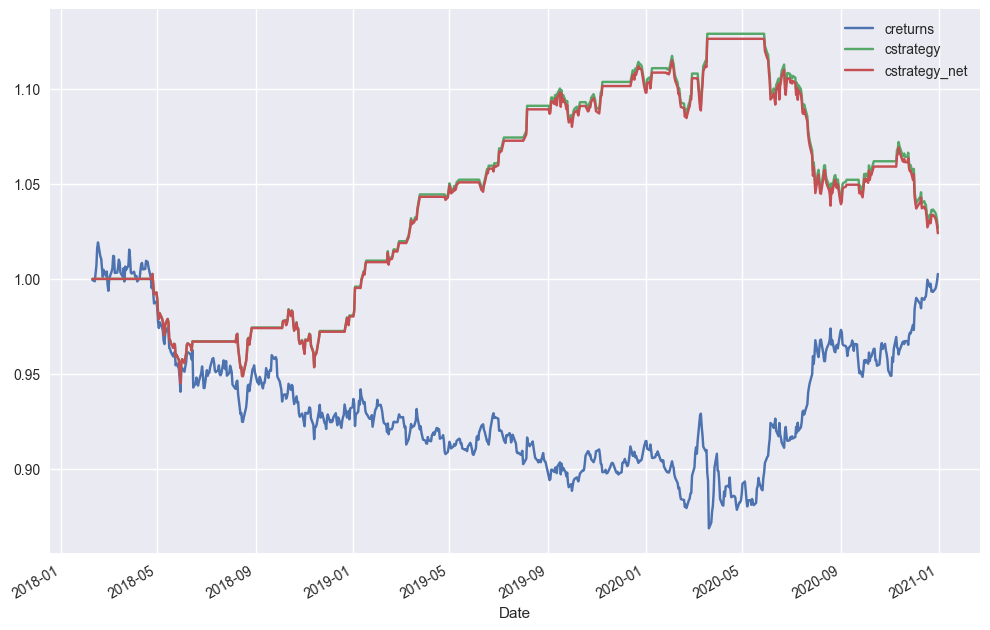

In [362]:
df[['creturns', 'cstrategy', 'cstrategy_net']].plot(figsize=(12, 8))
plt.show()

In [367]:
df[['returns', 'strategy_net']].mean() * 252

returns        0.0009
strategy_net   0.0079
dtype: float64

In [368]:
df[['returns', 'strategy_net']].std() * np.sqrt(4*252)

returns        0.1317
strategy_net   0.0889
dtype: float64